<h2>Real World ML Problem 2: StackOverflow Tag Prediction</h2>
>-Konark Verma

<b>DESCRIPTION</b>

>Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions as well as vote questions and answers up or down. 

>As of April 2014 Stack Overflow had over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.

<b>DATASET</b>

>The dataset contains content from disparate stack exchange sites, containing a mix of both technical and non-technical questions.

<b>OBJECTIVE</b>

> The task is to <b>predict the tags</b> (a.k.a. keywords, topics, summaries), given the question text and its title. 

<b>MOTIVATION</b>

> This problem has been inspired from the Kaggle Competition held by facebook. 

>Link to which is as follows: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

<b>BUISNESS OBJECTIVES and CONSTRAINTS</b>

> - Since, not predicting a correct tag, or incorrectly predicting a tag for a given question can result in degraded user experience, it is necessary that our model should have <b>high precision and recall values</b>.

> - This problem <b>does not</b> have a <b>strict latency constraint</b>.


In [1]:
# Importing the required libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from wordcloud import WordCloud

In [2]:
# Loading the data into pandas dataframe.

data = pd.read_csv('./Data/train.csv')
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [3]:
# Printing the number of datapoints and the names of the columns.

print('Number of datapoints in our dataset are: ',len(data))
print('Columns in our dataset: ',data.columns)

Number of datapoints in our dataset are:  6034195
Columns in our dataset:  Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')


<h2>Observations Summary Part-1:</h2>

>Size: 7GB

>Columns: ['Id', 'Title', 'Body', 'Tags']

>Number of raw datapoints: 6034195

> For each datapoint here, we have multiple space separated values for tags, so this is a <b>multi-label classification</b> problem.

Performance Metrics:

> 1. Hamming Loss
> 2. Also, as we want high precision and recall values, we can choose F1-score as our performance metric, but since this is a multi-label classification problem, we'll have to choose between the micro and macro F1 score. 


In [4]:
# Printing the number of unique and repeated titles, descriptions and title-body pairs for the given questions.

data_duplicate = data[data.duplicated(['Title','Body'])]
print('Number of repeated Title, Description pairs for questions are: ',len(data_duplicate))

data_duplicate = data.drop_duplicates(['Title','Body'])
print('Number of unique Title, Description pairs: ',len(data_duplicate))

data_duplicate = data[data.duplicated(['Id'])]
print('Number of repeated Ids for questions are: ',len(data_duplicate))

data_duplicate = data[data.duplicated(['Title'])]
print('Number of repeated Titles of questions are: ',len(data_duplicate))

data_duplicate = data.drop_duplicates(['Title'])
print('Number of unique Titles: ',len(data_duplicate))

data_duplicate = data[data.duplicated(['Body'])]
print('Number of repeated Descriptions of questions are: ',len(data_duplicate))

data_duplicate = data.drop_duplicates(['Body'])
print('Number of unique Titles: ',len(data_duplicate))

data_duplicate = data[data.duplicated(['Title','Body'], keep=False)].sort_values(by=['Title'])
data_duplicate.head(10)

Number of repeated Title, Description pairs for questions are:  1875970
Number of unique Title, Description pairs:  4158225
Number of repeated Ids for questions are:  0
Number of repeated Titles of questions are:  1908962
Number of unique Titles:  4125233
Number of repeated Descriptions of questions are:  1879814
Number of unique Titles:  4154381


<h2>Observations Summary Part-2:</h2>

>Number of repeated Title, Description pairs for questions are:  1875970

>Number of unique Title, Description pairs:  4158225

>Number of repeated Ids for questions are:  0

>Number of repeated Titles of questions are:  1908962

>Number of unique Titles:  4125233

>Number of repeated Descriptions of questions are:  1879814

>Number of unique Titles:  4154381

> *<i>Here, we note that there are certain datapoints which are exactly same except for the question Id, and Tags. So, it is important to merge the tags and remove the duplicates. </i>

In [5]:
# Dropping Question Id column, removing the duplicates and merging the tags for same title, body pairs.

data = data.drop(['Id'],axis=1)
data = data.drop_duplicates()

In [6]:
temp_data_1 = data.drop_duplicates(['Title','Body'],keep=False)
temp_data_2 = data[data.duplicated(['Title','Body'],keep=False)]

In [7]:
temp_data_2 = temp_data_2.sort_values(by=['Title','Body'])
temp_data_2.head(20)

,Title,Body,Tags
940625,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding
1484627,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns
3067777,"In OCaml, is it possible to define Map in ter...",<p>I have implemented a representation of sets...,module ocaml functor
5421479,"In OCaml, is it possible to define Map in ter...",<p>I have implemented a representation of sets...,homework ocaml
3184770,Looking for an html element/property that sho...,<p>These elements/properties should be able to...,html properties elements
3934927,Looking for an html element/property that sho...,<p>These elements/properties should be able to...,html properties
1633740,ON DUPLICATE KEY UPDATE implementation/design,"<p>I have a table, sessionBasket, that holds a...",query insert duplicates
3864365,ON DUPLICATE KEY UPDATE implementation/design,"<p>I have a table, sessionBasket, that holds a...",query update insert duplicates
1133854,POST after copy project and change package na...,"<p>hello i a problem with POST, all works in o...",android post package
2332122,POST after copy project and change package na...,"<p>hello i a problem with POST, all works in o...",android post package name


In [8]:
# Merging the tags values for the datapoints that had same Title-Body pairs.

temp_data_2 = list(temp_data_2.groupby(['Title','Body']))
tags_list = []
temp_df = []
for i in temp_data_2:
    tags = ''
    for j in i[1]['Tags']:
        tags = tags+' '+j
    tags = ' '.join(set(tags.split()))
    tags_list.append(tags)
    temp_val = i[1][:1]
    temp_df.append([temp_val['Title'].values[0],temp_val['Body'].values[0],temp_val['Tags'].values[0]])
temp_data_2 = pd.DataFrame(temp_df,columns=['Title','Body','Tags'])
temp_data_2['Tags'] = tags_list

del data_duplicate
del temp_df,temp_val,tags_list

temp_data_2.head()

,Title,Body,Tags
0,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,data-binding c# columns silverlight
1,"In OCaml, is it possible to define Map in ter...",<p>I have implemented a representation of sets...,homework module ocaml functor
2,Looking for an html element/property that sho...,<p>These elements/properties should be able to...,elements properties html
3,ON DUPLICATE KEY UPDATE implementation/design,"<p>I have a table, sessionBasket, that holds a...",query duplicates insert update
4,POST after copy project and change package na...,"<p>hello i a problem with POST, all works in o...",post name package android


In [9]:
# Concatinating the unique datapoints and the datapoints with different tags after merging their values.

data = pd.concat([temp_data_1,temp_data_2]).reset_index(drop=True)
del temp_data_1,temp_data_2
data.head()

,Title,Body,Tags
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [10]:
# Finding the count of each occurance of a tag, and number of tags for a question.

tags_dict={}
tags_count_dict={}
for tags in (data['Tags']):
    if len(tags.split()) in tags_count_dict:
        tags_count_dict[len(tags.split())] += 1
    else:
        tags_count_dict[len(tags.split())] = 1
    for tag in tags.split():
        if tag in tags_dict:
            tags_dict[tag] += 1
        else:
            tags_dict[tag] = 1

In [11]:
tags_count_dict

{1: 561207,
 2: 1095848,
 3: 1188885,
 4: 804484,
 5: 503152,
 6: 4221,
 7: 347,
 8: 68,
 9: 13}

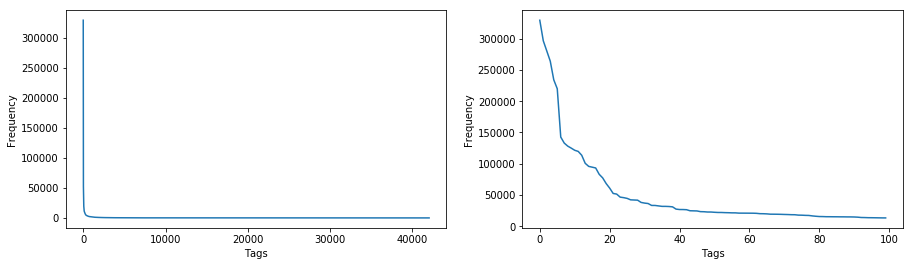

In [12]:
# Plotting the Tags vs Frequency graphs.

x = list(tags_dict.values())
x.sort(reverse=True)
figure = plt.figure(figsize=(15,4))
subfigure_1 = figure.add_subplot(121)
subfigure_1.set_xlabel('Tags')
subfigure_1.set_ylabel('Frequency')
subfigure_2 = figure.add_subplot(122)
subfigure_2.set_xlabel('Tags')
subfigure_2.set_ylabel('Frequency')
subfigure_1.plot(x)
subfigure_2.plot(x[:100])
plt.show()

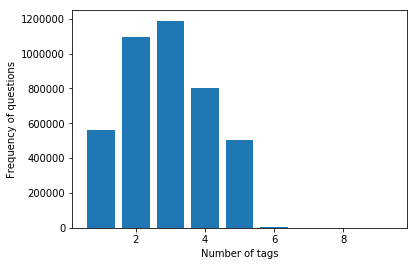

In [13]:
# Plotting the number of tags vs Frequency tags.

print(tags_count_dict)
plt.bar(tags_count_dict.keys(),tags_count_dict.values())
plt.xlabel('Number of tags')
plt.ylabel('Frequency of questions')
plt.show()

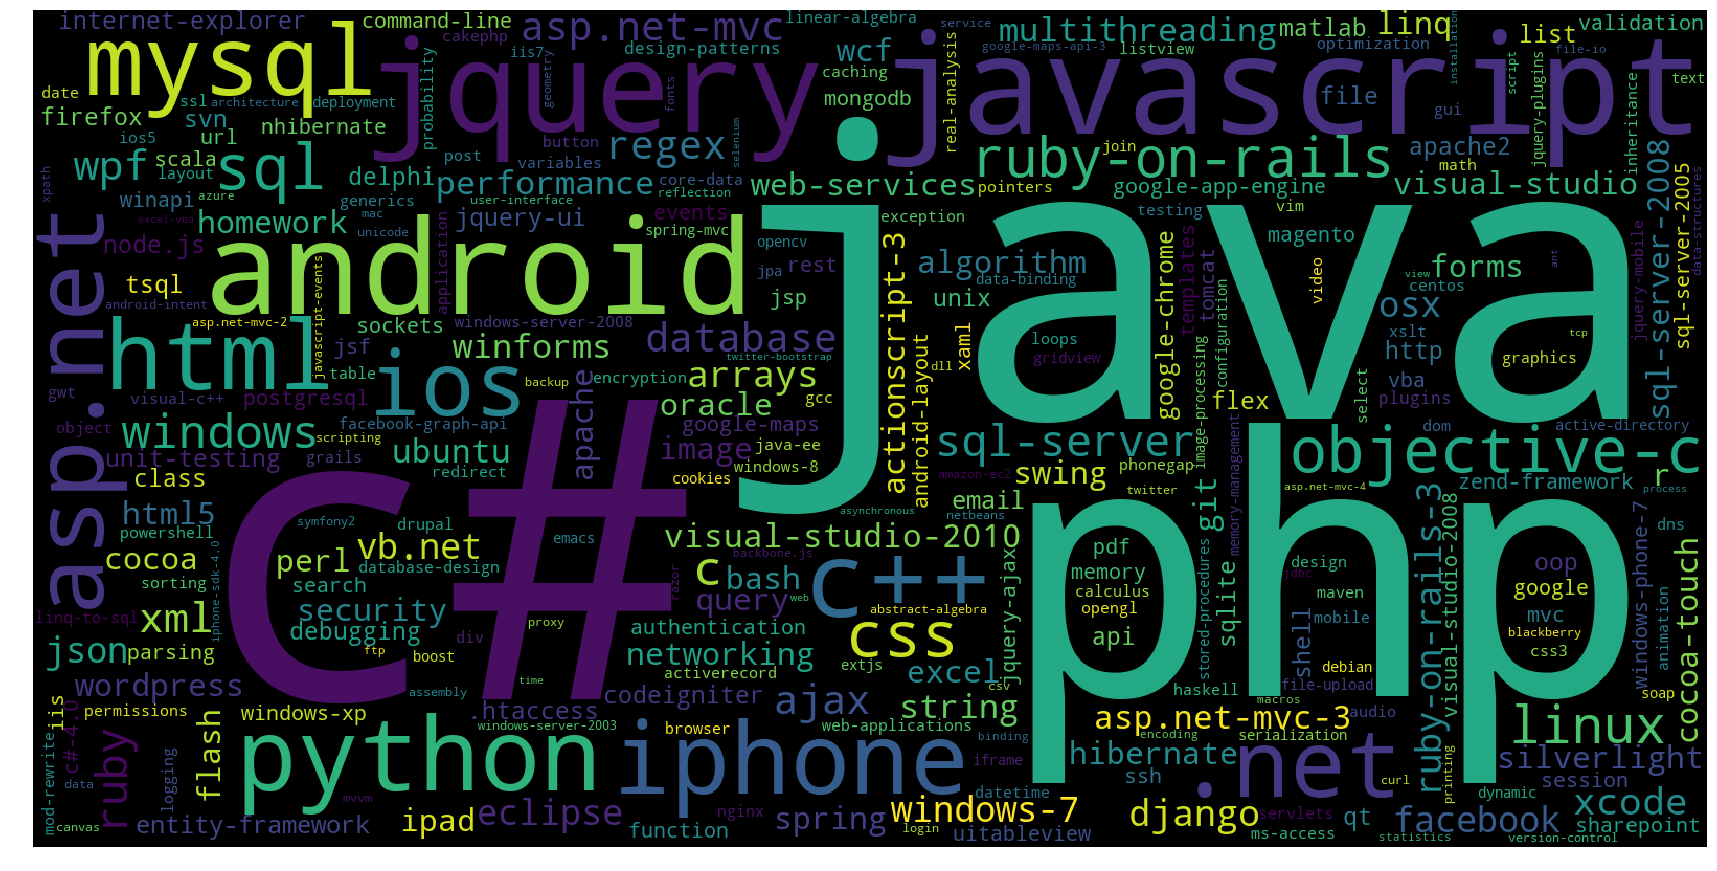

In [26]:
# Making the wordcloud poster for the tags, just for fun.

wordcloud = WordCloud(background_color='black',height=800,width=1600,max_words=300).generate_from_frequencies(tags_dict)
plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [78]:
pd.DataFrame([(k,v) for k,v in tags_dict.items()][:20]).sort_values(by=1,ascending=False).reset_index(drop=True)

,0,1
0,c#,329553
1,php,280409
2,asp.net,124914
3,r,19937
4,api,15890
5,firefox,13802
6,matlab,13356
7,windows-phone-7,12131
8,url,10733
9,active-directory,7325
